In [1]:
# dependencies for file reading
import json
import sys
import itertools
import numpy as np
import os
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import soundfile as sf

import librosa # conda install -c conda-forge librosa
import seaborn as sns

# managing parameters
from parammanager import paramManager
from sonyganformat import sonyGanJson
#from Tf_record import tfrecordManager

#Synth Interface (SI)
from genericsynth import synthInterface as SI # the base model for all synths, also some utilities 

#### Demo of synth interface using the single pop synth 

Note: MyPop and myPopPatternSynth are both synths that derive from the SI.MySoundModel class (and thus have the interface for parameter setting/getting as well as the generate() function for creating audio.

Here we load myPop just to see the interface in action. Normally it would only be used by myPopPatternSynth, and not loaded in a notebook or data set generating program. 

In [2]:
from myPop import MyPop   # This is the single-event synth that myPopPatternSynth uses [loading just for viz purposes]
foosynth=MyPop(880, 50)   # can (optionally) set params for a synth when you create an instance

foosynth.setParam('Q', 45) # Can set any synth parameter with setParam()
foosynth.getParam('Q')    # Get a param value. 

45

In [3]:
fmin = foosynth.getParam('cf_exp', "min")  # by default, getParam would get val, but here we ask for its min
print("min val of synth param f0 is {}".format(fmin))

foosynth.setParamNorm('cf_exp', 0)   #setParamNorm uses [0,1] range 
print("now the value of synth param f0 is {}".format(   foosynth.getParam('cf_exp')    ))


min val of synth param f0 is 100
now the value of synth param f0 is 100


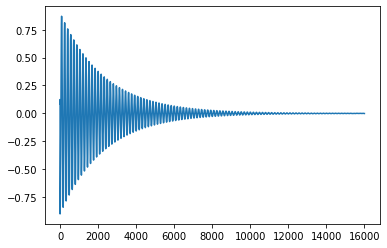

In [4]:
sig=foosynth.generate(1)   # all synths use generate to create audio. Parameter is length in seconds
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=True))

In [5]:
# A handy function to print the names and range of parameters using Synth
foosynth.printParams()

Name:  cf_exp  Default value :  100  Max value  2000  Min value  100
Name:  Q  Default value :  45  Max value  50  Min value  0.1


#### Demo of synth interface using the MyPopPatternSynth

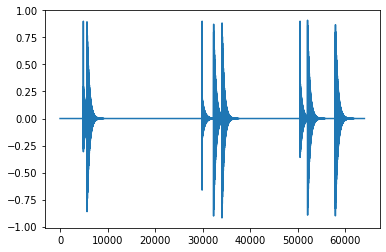

In [6]:
from myPopPatternSynth import MyPopPatternSynth

barsynth=MyPopPatternSynth()
barsynth.setParam("rate_exp",1) # will make 2^1 events per second
barsynth.setParam("irreg_exp", 1)
barsynth.setParam("Q", 40)

barsig=barsynth.generate(4)      # will generate 3 seconds of sound
plt.plot(barsig)
display(Audio(barsig, rate=16000, autoplay=True))

### Visualize distribution of events

Notice that this code is model-independent (uses only SI utility function, no synth methods)

number of events is 8000


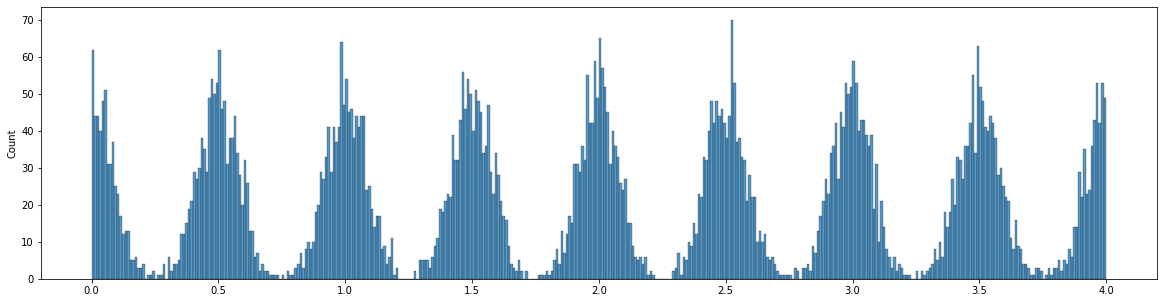

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

events=[]
for i in range(1000) :  #repeat to get enought samples to see the shape of the distribution
                                        #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds)
    events.extend(SI.noisySpacingTimeList(1, .5, 4))
print("number of events is {}".format(len(events)))
plt.figure(figsize=(20,5))
sns.histplot(events, bins=400)
plt.show()


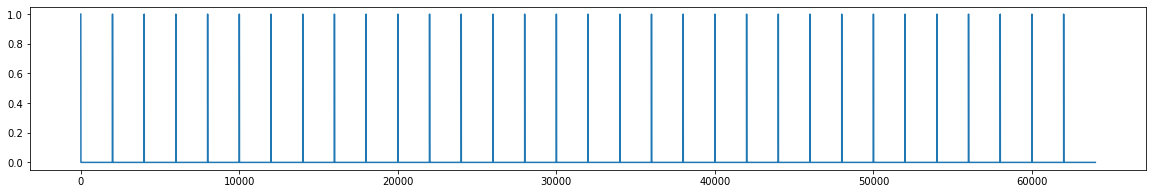

In [8]:
   #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds=p3)
elist = SI.noisySpacingTimeList(3, 0, 4)
esig = SI.timeList2Sig(elist,16000,4)

plt.figure(figsize=(20,3))
plt.plot(esig)

#### Demo of synth interface for dataset generation
1) Reading parameters from config_file.json <br>
2) Enumerating parameter values. <br>
3) Generating datasets from enumerated parameters

In [9]:
paramArr = []
data = []

config_file = './config_file.json'
with open(config_file) as json_file:
	data = json.load(json_file)
	print("Reading parameters for generating ", data['soundname'], " texture.. ")
	for p in data['params']:
	    print(p['pname'], ' Min: ', p['minval'], ' Max: ', p['maxval'])
	    paramArr.append(p)

Reading parameters for generating  pop_sound  texture.. 
rate  Min:  0.5  Max:  0.75
irreg  Min:  0  Max:  1
cf  Min:  500  Max:  800


In [10]:
# Config file Variables
sr = data['samplerate']
soundName = data["soundname"]
outPath = data["outPath"]
recordFormat = data["recordFormat"]
paramRange = data["paramRange"]
soundDuration = data["soundDuration"]
numVariations = data["numVariations"]

In [11]:
'''2 arrays for normalised and naturalised ranges'''
userRange = []
synthRange = []

if paramRange == "Norm":
    for p in paramArr:
        userRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))    
    for p in paramArr:
        synthRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))
else:
    for p in paramArr:
        userRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))    
    for p in paramArr:
        synthRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))

userParam = list(itertools.product(*userRange))
synthParam = list(itertools.product(*synthRange))
userParam

[(0.5, 0.0, 500.0),
 (0.5, 0.0, 800.0),
 (0.5, 1.0, 500.0),
 (0.5, 1.0, 800.0),
 (0.75, 0.0, 500.0),
 (0.75, 0.0, 800.0),
 (0.75, 1.0, 500.0),
 (0.75, 1.0, 800.0)]

#### Generate wav and param files for every parameter combination (listed above)

In [12]:
import soundfile as sf
from filewrite import fileHandler

fileHandle = fileHandler()
sg = sonyGanJson.SonyGanJson(data['soundname'],1, 16000, "POPTextureDS") # initializing

createFiles = True # Change this to true for dataset generation
outType = 1 # 0 for paramManager, 1 for sonyGan, 2 for tfrecords

if createFiles: 
    
    for index in range(len(userParam)): # caretesian product of lists
        
        userP = userParam[index]
        synthP = synthParam[index]

        #set parameters
        barsynth=MyPopPatternSynth()

        if paramRange == "Norm":
            barsynth.setParamNorm("rate_exp", synthP[0]) # will make 2^1 events per second
            barsynth.setParamNorm("irreg_exp", synthP[1])
            barsynth.setParamNorm("cf_exp", synthP[2])
        else:
            barsynth.setParam("rate_exp", synthP[0]) # will make 2^1 events per second
            barsynth.setParam("irreg_exp", synthP[1])
            barsynth.setParam("cf_exp", synthP[2])

        barsig=barsynth.generate(soundDuration)
        varDurationSecs=soundDuration/numVariations  #No need to floor this?

        for v in range(numVariations):

                '''Write wav'''
                wavName = fileHandle.makeName(soundName, paramArr, userP, v)
                wavPath = fileHandle.makeFullPath(outPath,wavName,".wav")
                chunkedAudio = SI.selectVariation(barsig, sr, v, varDurationSecs)
                sf.write(wavPath, chunkedAudio, sr)

                '''Write params'''
                paramName = fileHandle.makeName(soundName, paramArr, userP, v)
                pfName = fileHandle.makeFullPath(outPath, paramName,".params")

                if recordFormat == "params" or recordFormat==0:
                    pm=paramManager.paramManager(pfName, fileHandle.getFullPath())
                    pm.initParamFiles(overwrite=True)
                    for pnum in range(len(paramArr)):
                            pm.addParam(pfName, paramArr[pnum]['pname'], [0,soundDuration], [userP[pnum], userP[pnum]], units=paramArr[pnum]['units'], nvals=paramArr[pnum]['nvals'], minval=paramArr[pnum]['minval'], maxval=paramArr[pnum]['maxval'], origUnits=None, origMinval=barsynth.getParam(paramArr[pnum]['pname']+"_exp", "min"), origMaxval=barsynth.getParam(paramArr[pnum]['pname']+"_exp", "max"))
                            if paramRange == "Norm":
                                synthmin = barsynth.getParam(paramArr[pnum]['pname']+"_exp", "min")
                                synthmax = barsynth.getParam(paramArr[pnum]['pname']+"_exp", "max")
                                pm.addMetaParam(pfName, paramArr[pnum]['pname'], 
                                    {
                                    "user": "User maps parameters in Normalized units from 0-1 to " + str(paramArr[pnum]['minval']) + "-" + str(paramArr[pnum]['maxval']), 
                                    "synth": "Synth maps parameters from " + str(paramArr[pnum]['minval']) + "-" + str(paramArr[pnum]['maxval']) + " to " + str(synthmin + paramArr[pnum]['minval']*(synthmax-synthmin)) + "-" + str(synthmin + paramArr[pnum]['maxval']*(synthmax-synthmin))
                                    })
                            else:
                                pm.addMetaParam(pfName, paramArr[pnum]['pname'], 
                                                {
                                                    "user": "User maps " + paramRange + " units from " + str(paramArr[pnum]['minval']) + "->" + str(paramArr[pnum]['maxval']), 
                                                    "synth": "Synth maps in " + paramRange + " units from " + str(paramArr[pnum]['minval']) + "->" + str(paramArr[pnum]['maxval'])
                                                })
                elif recordFormat == "sonyGan" or outType == 1:

                    sg.storeSingleRecord(wavName)
                    for pnum in range(len(paramArr)):
                        sg.addParams(wavName, paramArr[pnum]['pname'], userP[pnum], barsynth.getParam(paramArr[pnum]['pname']+"_exp"))
                    sg.write2File("sonyGan.json")
                else:
                    print("Tfrecords")
                '''write TF record'''


pop_sound--rate-00.50--irreg-00.00--cf-500.00--v-000.params 
pop_sound--rate-00.50--irreg-00.00--cf-500.00--v-001.params 
pop_sound--rate-00.50--irreg-00.00--cf-800.00--v-000.params 
pop_sound--rate-00.50--irreg-00.00--cf-800.00--v-001.params 
pop_sound--rate-00.50--irreg-01.00--cf-500.00--v-000.params 
pop_sound--rate-00.50--irreg-01.00--cf-500.00--v-001.params 
pop_sound--rate-00.50--irreg-01.00--cf-800.00--v-000.params 
pop_sound--rate-00.50--irreg-01.00--cf-800.00--v-001.params 
pop_sound--rate-00.75--irreg-00.00--cf-500.00--v-000.params 
pop_sound--rate-00.75--irreg-00.00--cf-500.00--v-001.params 
pop_sound--rate-00.75--irreg-00.00--cf-800.00--v-000.params 
pop_sound--rate-00.75--irreg-00.00--cf-800.00--v-001.params 
pop_sound--rate-00.75--irreg-01.00--cf-500.00--v-000.params 
pop_sound--rate-00.75--irreg-01.00--cf-500.00--v-001.params 
pop_sound--rate-00.75--irreg-01.00--cf-800.00--v-000.params 
pop_sound--rate-00.75--irreg-01.00--cf-800.00--v-001.params 
